In [1]:
using Pkg
Pkg.add("Latexify");
Pkg.add("LaTeXStrings");
Pkg.add("LinearAlgebra");
Pkg.add("JuMP");
Pkg.add("Clp");
Pkg.add("PyPlot");
Pkg.add("NamedArrays")
Pkg.add("CSV");
Pkg.add("DataFrames");
Pkg.add("Ipopt");

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.t

# CS/ECE/ISyE 524 - Spr 2021 - HW 10
### Jacob Lorenz

# Problem 1 - Hexagon Construction

**The goal is to figure out the optimal geometry of a hexagon such that (1) the hexagon's area is maximized and (2) the hexagon's diameter does not exceed 1. The diameter of a hexagon is the largest distance between any pair of points belonging to the hexagon. Hints:**

- Place one of the vertices at the origin so you do not need as many decision variables
- A simple way of computing the area of a hexagon is to split it into four triangles that share a common vertex. The area of the hexagon is then the sum of the areas of the four triangles
- The optimal solution will look like a legitimate hexagon. It will not be degenerate, nor will it be perfectly regular.

**Plot a picture of the optimal hexagon.**

The formulation of this problem reduces to inscribing a polygon in a circle of diameter 1 such that the inscribed polygon has the largest area. To do so, we create decision variables $x_i,y_i$ for $i \in [1,6]$ to represent the x and y coordinates, respectively, of each vertex in our hexagon.

Since we can essentially fit an axis over the top of our diameter-1 circle, we let the first constraints represent the diameter constraint, such that all points are within the allowed diameter.

Given n vertices,

$$
    x_i^2 + y_i^2 \leq .25 \;\;\;\; \forall i \in [1,n]
$$

Next, we add ordering constraints to each of the vertices

$$
    x_i*y_{i+1} - y_i*x_{i+1} \geq 0 \;\;\;\; \forall i \in [1,n-1] \\
    x_n*y_1 - y_n*x_1 \geq 0
$$

Finally, we calculate our objective by dividing the region into triangular ones and finding the sum of all triagnular regions.

$$
    \max_{x,y} \frac{1}{2} * \sum_{i=1}^{n-1} ({x_i * y_{i+1} - y_i * x_{i+1}}) + (x_n * y_1 - y_n * x_1)
$$

In [3]:
using PyPlot, JuMP, Ipopt, Random

# x = [1, 2, 3, 2, 1, 0]
# y = [0, 0, 1, 2, 2, 1]

function findOptimalInscribedPolygon(n)
    m = Model(Ipopt.Optimizer)
    @variable(m, x[1:n] )
    @variable(m, y[1:n] )

    # Diameter constraints
    for i = 1:n
        @constraint(m, x[i]^2 + y[i]^2 <= .25)
    end

    # Add ordering constraint to the vertices
    for i = 1:n-1
        @NLconstraint(m, x[i]*y[i+1]-y[i]*x[i+1] >= 0 )
    end
    @NLconstraint(m, x[n]*y[1]-y[n]*x[1] >= 0 )
    
    # Calculate the areas via triangle regions
    @NLexpression(m, firstRegionArea, 0.5*(x[n]*y[1]-y[n]*x[1]))
    @NLexpression(m, remainingRegionsArea, 0.5*sum( x[i]*y[i+1]-y[i]*x[i+1] for i=1:n-1))
    @NLexpression(m, totalArea, firstRegionArea + remainingRegionsArea)
    
    @NLobjective(m, Max, totalArea)

    # Seed the x and y values such that we do not end up with 0
    Random.seed!(2367877)

    set_start_value.(x,rand(n))
    set_start_value.(y,rand(n))
    
    optimize!(m)
    xopt = value.([x; x[1]])
    yopt = value.([y; y[1]])
    return (xopt, yopt, objective_value(m))
end

findOptimalInscribedPolygon (generic function with 1 method)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       36
Number of nonzeros in Lagrangian Hessian.............:       72

Total number of variables............................:       12
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

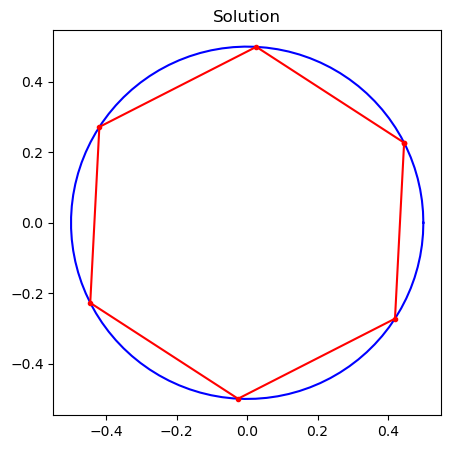

0.6495190647186021

Coordinates:


6×2 Array{Float64,2}:
  0.445377    0.227243
  0.0258903   0.499329
 -0.419487    0.272086
 -0.445377   -0.227243
 -0.0258903  -0.499329
  0.419487   -0.272086

In [4]:
n_hexagon = 6;
(xopt,yopt,aopt) = findOptimalInscribedPolygon(n_hexagon)

t = range(0,stop=2π,length=100) 
figure(figsize=[5,5])
plot( 0.5*cos.(t), 0.5*sin.(t), "b-" )
plot( xopt, yopt, "r.-" )
axis("equal");
axis("on");

title("Solution")
;

println()
print("Area of Optimal ", n_hexagon, " Sided Polynomial: ")
println(aopt)
println()
println("Coordinates:")
[xopt[1:6] yopt[1:6]]

Based on the results above, we can see that the optimal area for a 6-sided polygon contained within a circle of diameter 1 is 0.6495190647186021, and the polygon is indeed a legitimate hexagon. It is curious; however, that the optimal hexagon is depicted as being off-center. Given the symmetry, it seems that any arrangement around the circle with the same distance between vertices would provide the exact same optimal area, theoretically meaning an infinite number of solutions. I guess the solution shown was derived from the starting seed values for x and y.

# Problem 2 - Fertilizer Influence Model

**A series of experiments is conducted to determine the effect of a particular fertilizer on wheat crop yield. The results are shown in the homework 10 writeup.**

**Such situations typically involve some sort of diminishing returns. So there is a limit to how much the fertilizer can boost the yield. A popular model for this relationship is the following:**

$$
    y = k_1 + k_2 * exp(k_3 * x)
$$

**Use nonlinear least squares to determine the values of ($k_1,k_2,k_3$) that provide the best fit to the data. We can expect coefficients in the neighborhood of (500, -200, -1).**

**Produce a plot of the original data pioints and the best fit curve.**

Nonlinear least squares is essentially the same as linear least squares, just that the proposed expression for $\hat{y}$ is nonlinear in nature. Therefore, we are looking to minimize

$$
    \sum_{i = 1}^N {y_i - (k_1 + k_2 * e^{k_3 * x_i})}
$$

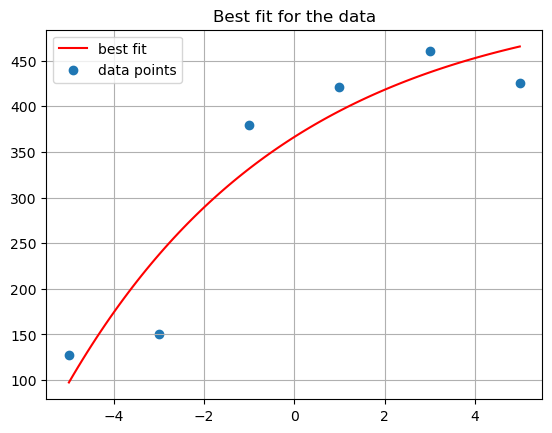

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [40]:
using JuMP, Ipopt, PyPlot

x = [-5, -3, -1, 1, 3, 5]
y = [127, 151, 379, 421, 460, 426]

n = 6

function nonlinearLeastSquares(k1est, k2est, k3est)
    m2 = Model(Ipopt.Optimizer)

    @variable(m2, k[1:3])
    @NLobjective(m2, Min, sum((y[i] - (k[1] + k[2] * exp(k[3] * x[i])))^2 for i in 1:n))

    set_start_value.(k[1],k1est)
    set_start_value.(k[2],k2est)
    set_start_value.(k[3],k3est)
    
    optimize!(m2)
    return (value.(k[1]), value.(k[2]), value.(k[3]),objective_value(m2))
end

k1est = 500
k2est = -200
k3est = -1

(k1,k2,k3,obj) = nonlinearLeastSquares(k1est, k2est, k3est);

println("Optimal Parameters:")
print("k1: ")
println(k1)
print("k2: ")
println(k2)
print("k3: ")
println(k3)
print("LS Error: ")
println(obj)


# Plot the data and the best-fit curve
xv = range(-5, stop=5, length=100)
yv = zeros(length(xv))
for i in 1:length(xv)
    yv[i] = k1 + k2 * exp(k3*xv[i])
end

scatter(x, y, label="data points")
plot(xv, yv, "r-", label="best fit")
grid()
legend(loc="best"); title("Best fit for the data")

;

From the results above, we see that the optimal parameters / exponential equation to model our fertilizer data was

$$
    y = 523.3055 - 156.909478 * e^{-.01996646x}
$$

Although the squared error is rather high, 13390, we can see visually that the estimated curve of best fit tracks nicely with the data points and provides a nice intermediary curve to describe the diminishing returns.